# GAN Models 

Generative Adversarial Networks (GANs) are a class of machine learning models that uses two neural networks to learn. GANs have several applications for machine learning including image generation, data augmentation, and text to image generation. 

The architecture of a GAN consistents of the generator and the discriminator. The discriminator trains itself to distinguish between real and fake data, while the generator trains itself to create data that the discriminator will think is real. 

#### Videos

https://www.youtube.com/watch?v=OW_2zFqQ1TA&list=PLL0SWcFqypCl4lrzk1dMWwTUrzQZFt7y0&index=30 (Generative Adversarial Networks)

https://www.youtube.com/watch?v=jCXGKWDd4f8&list=PLL0SWcFqypCl4lrzk1dMWwTUrzQZFt7y0&index=31 (Application of GANs in Materials Science)

## Basic GAN Implementation

First we will learn how to implement a GAN model to generate images. We will specifically be using the dendrite images from Foundry. Lets import the libraries and load the data. Our GAN model will come from PyTorch.

This notebook is adapted from https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

In [1]:
import torch
from torch import nn
import torchvision 
import torch.optim as optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(0)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')




/opt/miniconda3/envs/masterENV/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/miniconda3/envs/masterENV/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/miniconda3/envs/masterENV/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <EDCC189C-6D3F-3948-87DF-FA6A06787893> /opt/miniconda3/envs/masterENV/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import foundry as foundry

f = foundry.Foundry()

# Load data
datasets = f.search("foundry_stan_segmentation_v1.1")
dataset = f.get_dataset('10.18126/d4kn-cz3p')
# load the images from the dataset dictionary 

res = dataset.load()
image = res['train']['target']['train/output']

In [3]:
# example of defining the discriminator model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
import cv2

In [4]:
# Convert images to grayscale and resize to 28x28
def convert_and_resize_images(images, target_size=(28, 28)):
    resized_images = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, target_size)
        resized_images.append(resized)
    return np.array(resized_images)

# Assuming 'images' is your numpy array of images with shape (num_images, 852, 852, 3)
resized_images = convert_and_resize_images(image)
resized_images = np.expand_dims(resized_images, axis=-1)  # Add channel dimension
print("Resized images shape:", resized_images.shape)  # Should be (num_images, 28, 28, 1)


Resized images shape: (30, 28, 28, 1)


In [5]:
# Define the discriminator model for 28x28 images
def discriminator(in_shape=(28, 28, 1)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [6]:
# define model
model = discriminator()
# summarize the model
model.summary()
# plot the model

/opt/miniconda3/envs/masterENV/lib/python3.11/site-packages/keras/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/miniconda3/envs/masterENV/lib/python3.11/site-packages/keras/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,113 (195.75 KB)

 Trainable params: 50,113 (195.75 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Load and prepare the dataset
def load_real_samples(images):
    # Convert from unsigned ints to floats
    X = images.astype('float32')
    # Scale from [0, 255] to [-1, 1]
    X = (X - 127.5) / 127.5
    return X

# Select real samples
def generate_real_samples(dataset, n_samples):
    # Choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # Retrieve selected images
    X = dataset[ix]
    # Generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y


# Generate fake samples with class labels
def generate_fake_samples(n_samples):
    # Generate uniform random numbers in [-1, 1]
    X = (rand(n_samples, 28, 28, 1) - 0.5) * 2
    # Generate 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

# Train the discriminator model
def train_discriminator(model, dataset, n_iter=10, n_batch=256):
    half_batch = int(n_batch / 2)
    # Manually enumerate epochs
    for i in range(n_iter):
        # Get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # Update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # Generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # Update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # Summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i + 1, real_acc * 100, fake_acc * 100))

In [8]:
# Define the discriminator model
model = discriminator()

# Load and prepare the dataset
dataset = load_real_samples(resized_images)

# Fit the model
train_discriminator(model, dataset)

>1 real=39% fake=48%


>2 real=63% fake=66%


>3 real=73% fake=74%
>4 real=78% fake=79%
>5 real=82% fake=83%
>6 real=85% fake=86%
>7 real=87% fake=88%
>8 real=89% fake=90%
>9 real=90% fake=91%
>10 real=91% fake=92%


In [9]:
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
# define the standalone generator model
def define_generator(latent_dim):
 model = Sequential()
 # foundation for 7x7 image
 n_nodes = 128 * 7 * 7
 model.add(Dense(n_nodes, input_dim=latent_dim))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Reshape((7, 7, 128)))
 # upsample to 14x14
 model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 # upsample to 28x28
 model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
 return model

In [10]:
# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()

/opt/miniconda3/envs/masterENV/lib/python3.11/site-packages/keras/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 6272)           │       633,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,164,289 (4.44 MB)

 Trainable params: 1,164,289 (4.44 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from numpy.random import randn
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [12]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [13]:
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


In [14]:

# demonstrate creating the three models in the gan
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
 

In [15]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
 model = Sequential()
 model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Dropout(0.4))
 model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Dropout(0.4))
 model.add(Flatten())
 model.add(Dense(1, activation='sigmoid'))
 # compile model
 opt = Adam(learning_rate=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
 return model

In [16]:
# define the standalone generator model
def define_generator(latent_dim):
 model = Sequential()
 # foundation for 7x7 image
 n_nodes = 128 * 7 * 7
 model.add(Dense(n_nodes, input_dim=latent_dim))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Reshape((7, 7, 128)))
 # upsample to 14x14
 model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 # upsample to 28x28
 model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
 return model

In [17]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
 # make weights in the discriminator not trainable
 d_model.trainable = False
 # connect them
 model = Sequential()
 # add generator
 model.add(g_model)
 # add the discriminator
 model.add(d_model)
 # compile model
 opt = Adam(learning_rate=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt)
 return model

In [18]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ ?                      │     1,164,289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ ?                      │        40,705 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,204,994 (4.60 MB)

 Trainable params: 1,164,289 (4.44 MB)

 Non-trainable params: 40,705 (159.00 KB)

In [19]:
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
 # manually enumerate epochs
 for i in range(n_epochs):
    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))
    # update the generator via the discriminator's error
    gan_model.train_on_batch(x_gan, y_gan)

In [20]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

In [21]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0])
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
            # evaluate the model performance, sometimes
            if (i+1) % 10 == 0:
                summarize_performance(i, g_model, d_model, dataset, latent_dim)
                

In [22]:
from matplotlib import pyplot
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
        # save plot to file
        filename = 'generated_plot_e%03d.png' % (epoch+1)
        pyplot.savefig(filename)
        pyplot.close()

In [23]:

# example of loading the generator model and generating images
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
        pyplot.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/opt/miniconda3/envs/masterENV/lib/python3.11/site-packages/keras/backend/tensorflow/trainer.py:74: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


>1, 1/30, d=0.721, g=0.642
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1, 2/30, d=0.719, g=0.641
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1, 3/30, d=0.721, g=0.642
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>1, 4/30, d=0.720, g=0.641
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1, 5/30, d=0.720, g=0.640
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
>1, 6/30, d=0.720, g=0.639
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
>1, 7/30, d=0.720, g=0.637
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>1, 8/30, d=0.721, g=0.636
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
>1, 9/30, d=0.721, g=0.635
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>1, 10/30, d=0.722, g=0.634
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
>1, 11/30, d=0.723, g=0.632
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
>1, 12/30, d=0.724, g=0.631
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
>1, 13/30, d=0.725, g=0.629
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
>1, 14/30, d=0.726, g=0.627
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
>1, 15/30, d=0.728, g=0.626
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1, 16/30, d=0.728,

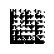

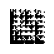

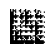

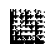

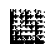

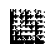

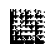

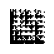

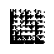

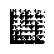

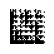

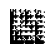

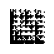

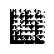

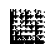

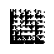

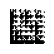

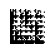

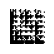

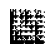

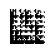

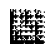

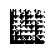

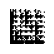

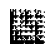

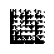

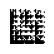

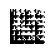

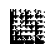

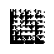

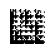

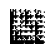

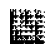

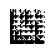

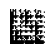

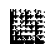

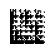

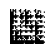

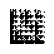

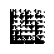

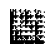

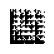

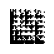

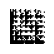

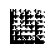

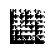

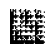

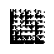

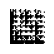

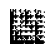

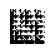

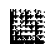

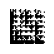

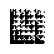

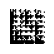

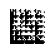

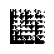

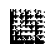

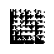

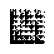

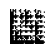

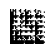

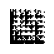

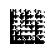

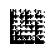

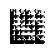

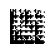

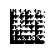

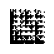

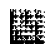

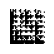

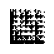

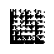

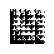

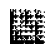

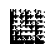

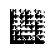

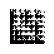

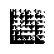

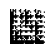

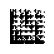

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>10, 2/30, d=1.098, g=0.457
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
>Accuracy real: 0%, fake: 0%


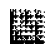

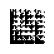

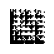

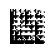

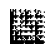

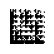

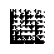

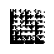

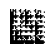

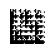

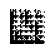

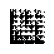

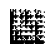

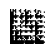

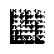

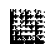

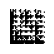

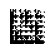

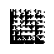

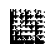

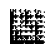

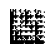

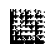

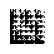

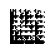

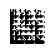

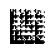

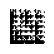

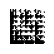

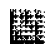

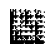

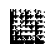

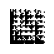

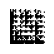

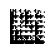

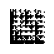

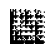

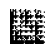

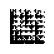

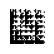

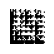

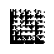

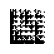

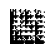

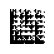

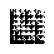

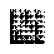

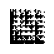

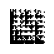

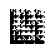

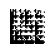

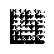

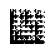

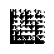

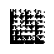

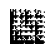

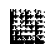

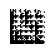

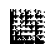

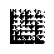

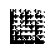

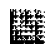

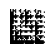

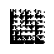

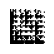

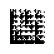

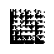

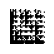

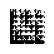

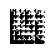

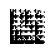

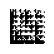

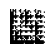

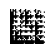

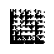

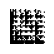

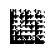

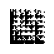

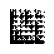

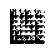

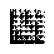

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>10, 3/30, d=1.097, g=0.457
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>Accuracy real: 0%, fake: 0%


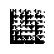

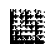

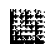

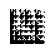

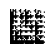

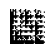

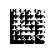

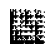

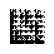

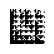

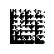

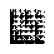

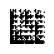

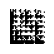

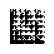

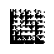

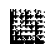

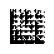

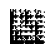

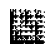

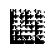

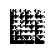

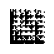

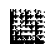

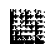

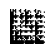

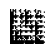

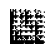

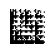

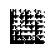

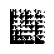

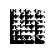

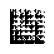

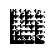

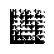

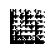

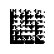

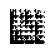

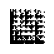

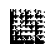

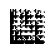

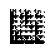

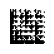

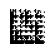

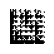

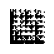

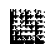

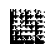

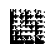

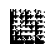

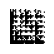

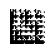

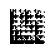

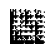

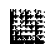

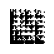

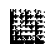

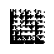

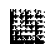

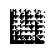

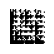

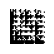

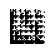

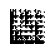

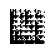

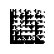

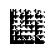

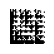

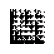

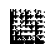

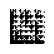

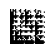

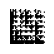

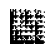

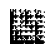

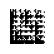

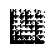

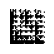

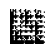

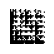

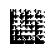

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>10, 4/30, d=1.098, g=0.457
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
>Accuracy real: 0%, fake: 0%


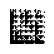

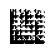

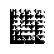

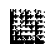

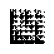

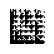

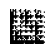

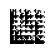

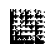

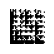

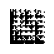

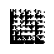

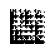

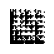

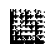

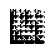

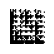

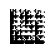

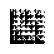

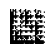

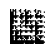

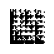

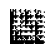

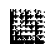

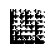

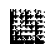

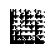

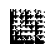

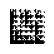

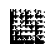

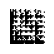

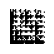

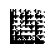

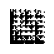

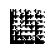

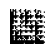

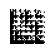

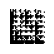

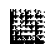

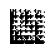

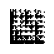

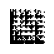

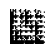

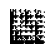

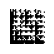

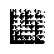

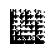

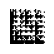

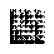

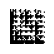

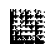

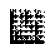

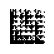

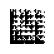

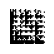

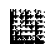

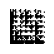

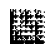

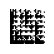

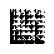

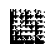

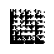

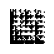

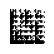

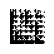

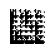

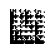

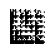

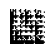

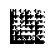

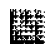

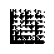

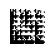

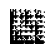

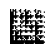

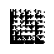

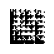

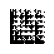

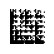

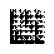

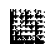

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>10, 5/30, d=1.099, g=0.456
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>Accuracy real: 0%, fake: 0%


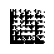

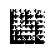

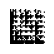

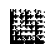

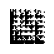

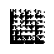

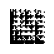

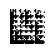

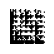

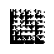

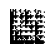

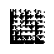

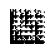

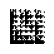

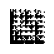

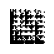

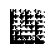

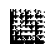

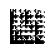

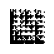

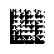

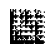

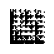

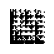

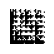

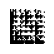

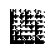

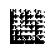

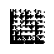

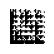

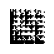

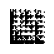

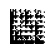

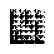

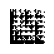

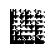

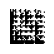

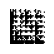

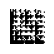

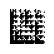

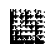

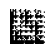

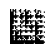

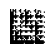

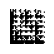

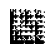

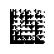

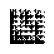

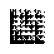

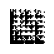

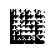

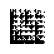

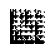

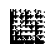

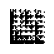

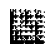

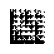

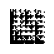

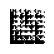

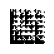

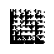

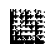

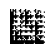

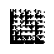

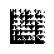

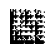

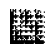

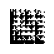

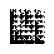

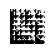

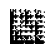

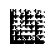

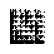

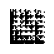

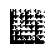

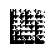

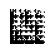

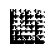

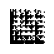

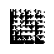

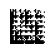

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>10, 6/30, d=1.096, g=0.456
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step 
>Accuracy real: 0%, fake: 0%


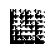

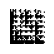

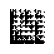

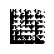

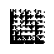

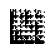

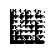

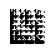

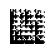

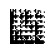

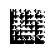

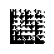

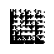

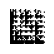

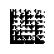

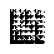

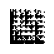

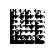

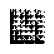

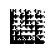

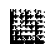

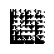

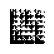

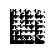

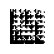

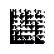

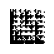

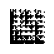

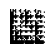

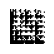

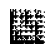

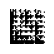

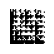

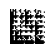

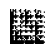

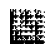

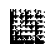

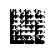

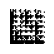

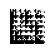

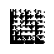

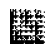

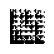

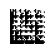

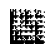

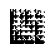

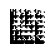

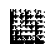

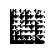

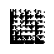

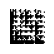

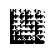

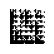

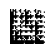

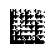

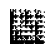

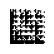

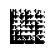

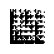

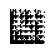

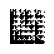

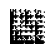

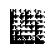

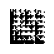

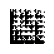

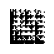

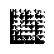

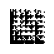

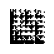

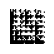

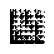

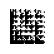

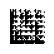

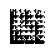

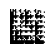

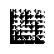

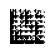

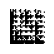

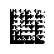

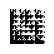

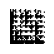

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>10, 7/30, d=1.099, g=0.456
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>Accuracy real: 0%, fake: 0%


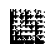

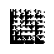

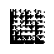

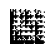

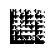

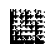

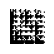

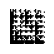

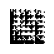

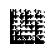

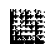

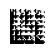

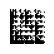

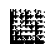

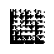

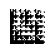

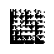

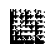

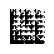

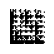

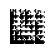

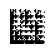

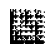

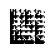

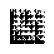

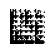

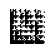

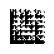

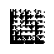

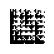

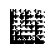

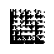

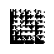

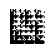

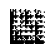

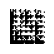

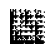

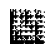

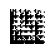

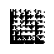

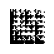

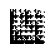

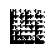

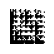

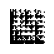

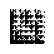

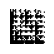

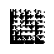

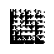

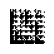

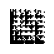

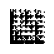

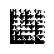

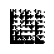

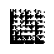

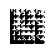

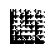

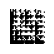

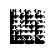

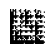

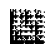

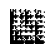

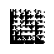

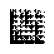

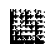

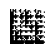

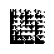

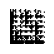

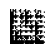

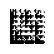

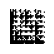

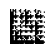

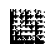

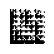

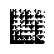

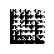

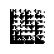

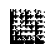

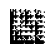

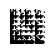

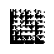

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
>10, 8/30, d=1.097, g=0.456
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>Accuracy real: 0%, fake: 0%


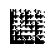

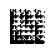

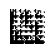

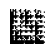

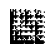

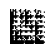

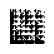

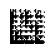

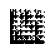

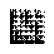

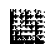

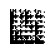

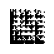

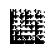

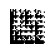

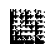

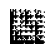

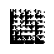

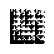

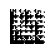

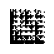

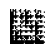

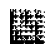

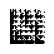

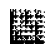

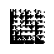

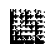

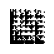

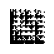

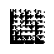

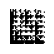

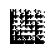

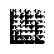

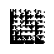

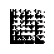

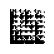

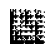

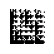

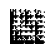

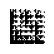

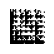

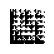

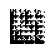

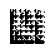

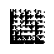

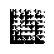

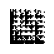

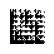

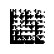

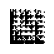

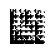

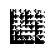

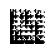

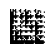

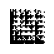

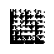

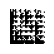

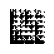

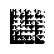

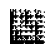

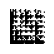

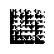

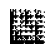

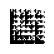

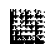

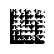

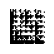

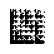

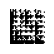

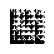

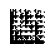

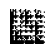

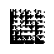

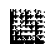

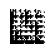

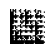

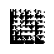

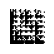

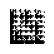

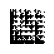

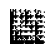

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>10, 9/30, d=1.097, g=0.455
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
>Accuracy real: 0%, fake: 0%


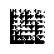

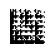

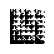

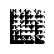

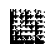

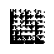

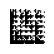

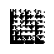

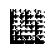

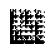

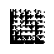

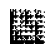

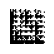

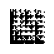

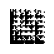

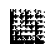

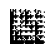

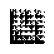

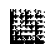

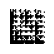

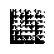

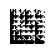

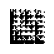

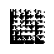

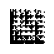

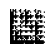

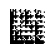

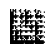

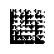

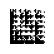

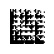

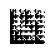

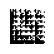

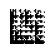

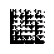

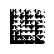

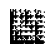

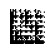

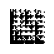

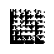

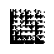

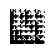

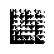

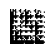

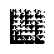

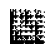

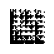

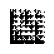

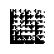

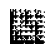

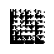

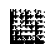

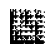

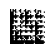

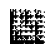

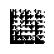

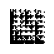

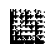

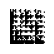

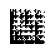

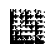

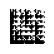

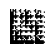

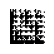

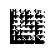

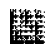

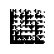

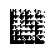

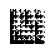

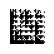

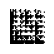

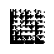

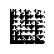

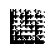

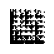

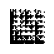

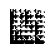

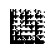

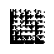

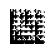

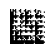

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>10, 10/30, d=1.098, g=0.455
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>Accuracy real: 0%, fake: 0%


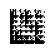

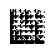

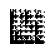

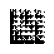

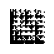

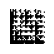

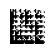

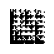

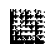

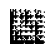

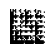

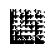

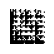

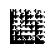

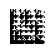

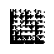

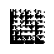

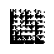

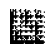

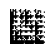

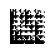

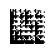

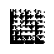

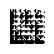

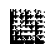

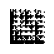

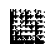

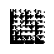

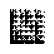

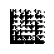

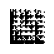

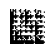

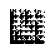

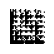

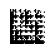

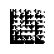

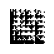

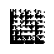

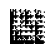

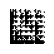

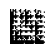

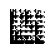

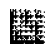

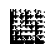

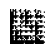

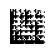

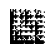

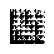

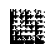

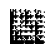

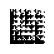

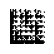

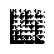

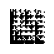

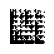

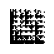

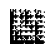

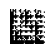

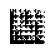

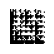

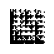

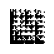

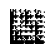

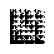

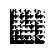

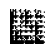

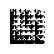

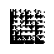

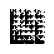

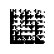

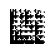

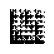

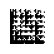

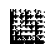

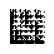

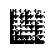

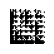

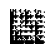

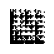

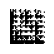

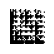

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>10, 11/30, d=1.099, g=0.455
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>Accuracy real: 0%, fake: 0%


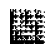

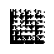

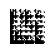

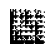

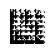

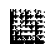

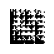

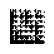

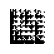

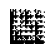

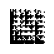

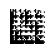

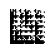

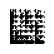

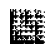

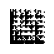

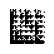

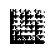

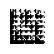

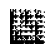

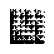

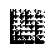

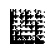

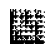

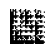

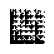

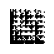

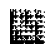

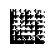

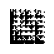

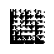

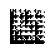

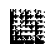

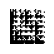

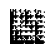

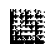

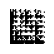

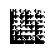

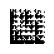

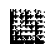

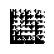

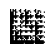

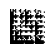

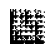

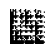

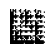

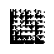

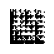

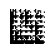

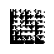

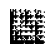

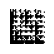

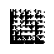

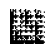

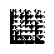

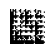

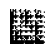

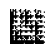

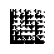

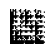

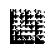

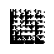

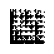

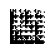

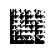

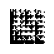

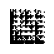

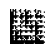

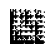

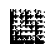

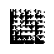

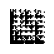

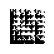

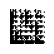

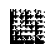

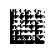

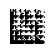

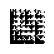

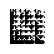

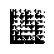

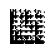

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>10, 12/30, d=1.100, g=0.455
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>Accuracy real: 0%, fake: 0%


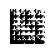

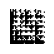

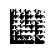

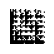

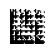

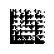

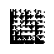

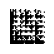

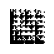

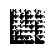

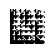

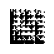

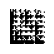

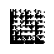

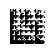

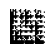

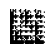

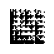

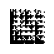

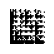

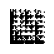

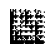

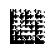

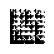

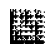

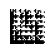

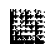

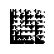

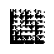

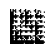

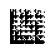

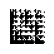

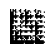

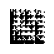

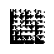

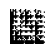

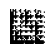

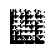

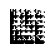

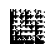

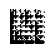

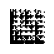

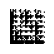

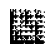

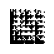

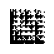

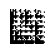

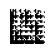

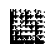

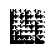

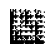

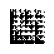

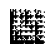

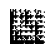

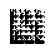

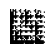

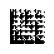

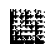

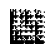

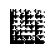

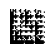

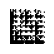

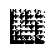

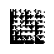

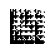

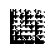

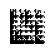

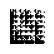

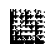

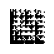

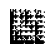

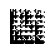

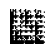

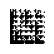

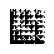

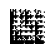

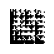

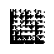

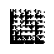

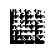

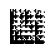

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>10, 13/30, d=1.099, g=0.454
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
>Accuracy real: 0%, fake: 0%


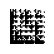

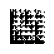

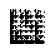

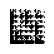

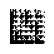

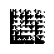

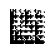

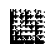

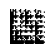

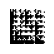

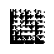

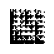

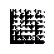

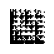

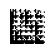

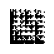

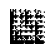

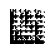

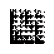

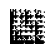

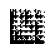

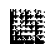

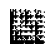

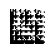

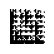

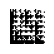

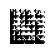

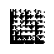

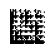

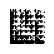

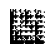

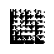

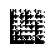

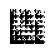

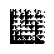

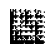

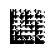

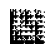

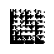

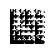

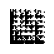

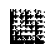

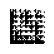

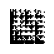

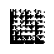

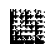

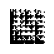

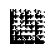

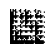

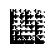

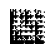

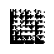

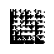

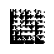

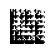

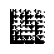

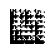

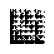

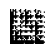

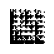

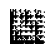

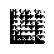

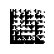

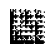

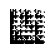

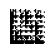

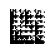

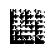

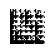

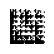

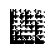

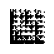

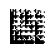

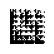

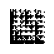

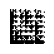

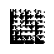

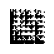

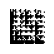

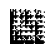

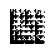

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>10, 14/30, d=1.099, g=0.454
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>Accuracy real: 0%, fake: 0%


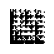

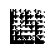

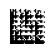

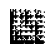

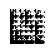

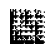

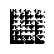

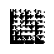

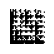

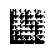

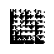

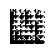

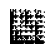

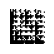

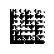

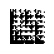

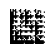

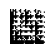

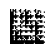

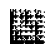

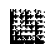

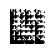

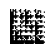

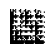

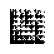

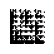

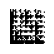

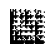

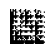

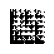

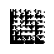

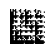

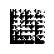

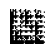

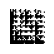

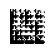

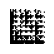

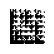

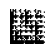

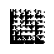

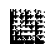

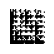

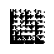

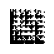

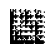

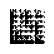

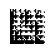

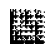

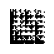

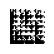

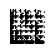

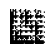

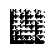

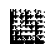

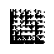

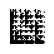

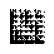

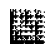

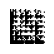

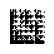

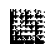

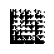

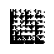

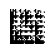

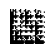

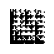

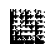

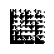

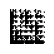

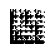

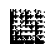

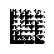

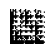

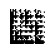

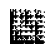

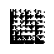

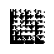

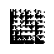

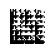

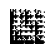

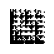

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>10, 15/30, d=1.101, g=0.454
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
>Accuracy real: 0%, fake: 0%


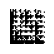

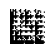

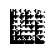

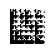

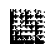

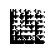

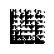

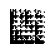

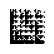

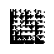

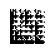

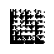

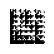

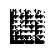

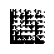

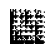

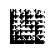

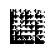

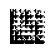

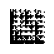

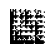

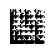

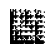

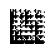

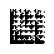

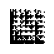

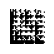

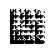

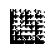

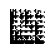

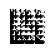

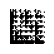

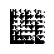

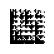

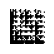

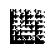

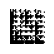

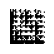

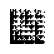

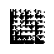

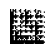

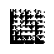

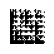

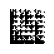

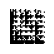

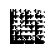

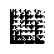

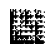

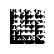

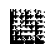

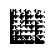

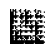

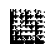

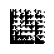

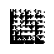

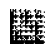

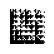

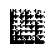

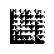

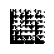

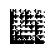

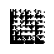

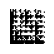

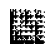

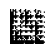

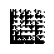

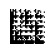

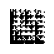

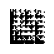

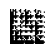

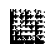

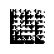

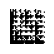

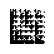

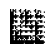

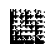

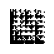

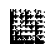

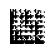

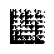

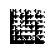

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>10, 16/30, d=1.098, g=0.454
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>Accuracy real: 0%, fake: 0%


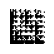

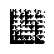

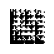

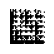

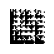

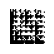

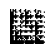

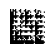

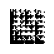

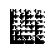

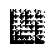

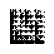

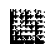

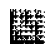

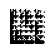

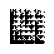

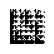

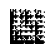

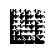

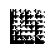

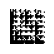

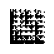

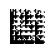

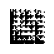

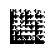

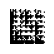

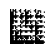

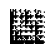

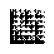

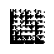

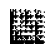

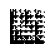

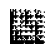

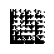

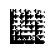

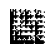

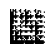

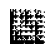

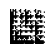

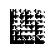

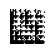

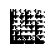

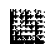

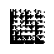

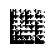

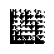

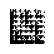

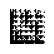

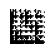

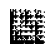

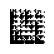

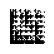

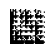

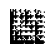

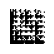

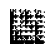

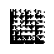

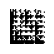

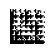

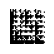

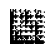

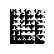

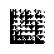

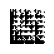

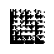

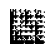

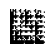

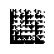

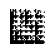

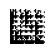

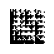

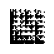

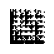

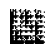

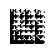

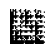

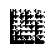

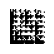

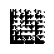

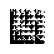

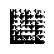

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>10, 17/30, d=1.098, g=0.454
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>Accuracy real: 0%, fake: 0%


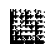

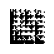

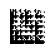

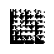

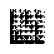

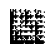

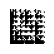

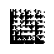

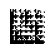

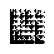

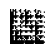

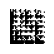

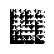

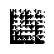

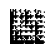

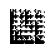

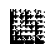

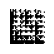

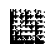

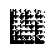

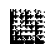

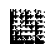

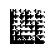

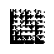

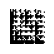

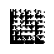

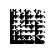

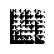

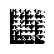

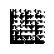

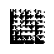

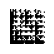

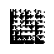

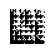

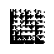

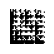

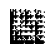

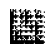

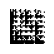

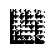

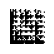

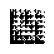

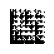

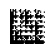

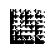

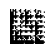

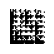

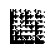

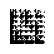

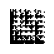

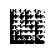

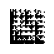

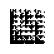

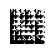

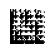

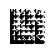

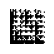

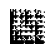

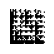

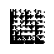

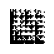

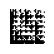

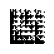

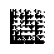

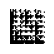

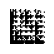

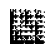

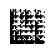

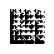

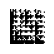

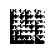

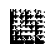

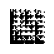

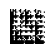

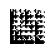

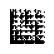

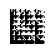

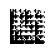

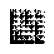

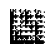

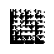

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>10, 18/30, d=1.099, g=0.453
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>Accuracy real: 0%, fake: 0%


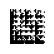

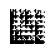

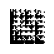

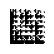

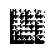

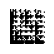

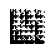

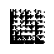

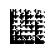

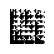

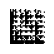

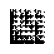

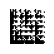

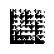

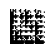

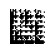

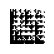

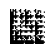

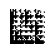

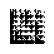

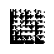

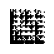

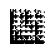

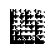

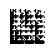

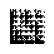

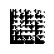

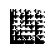

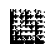

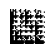

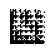

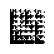

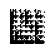

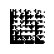

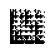

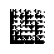

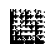

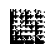

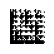

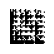

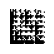

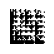

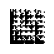

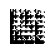

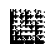

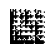

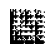

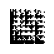

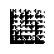

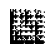

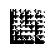

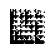

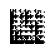

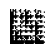

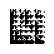

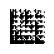

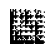

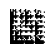

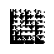

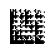

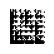

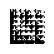

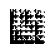

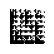

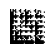

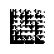

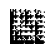

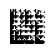

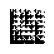

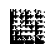

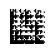

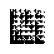

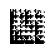

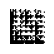

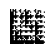

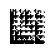

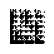

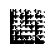

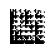

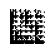

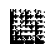

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>10, 19/30, d=1.100, g=0.453
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>Accuracy real: 0%, fake: 0%


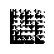

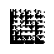

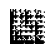

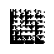

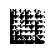

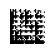

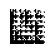

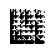

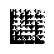

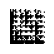

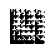

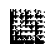

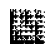

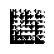

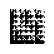

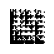

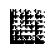

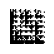

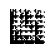

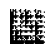

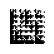

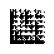

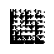

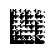

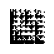

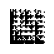

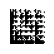

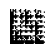

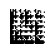

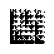

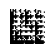

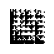

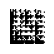

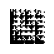

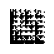

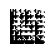

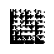

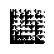

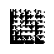

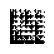

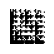

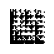

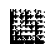

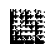

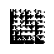

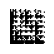

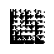

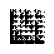

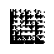

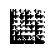

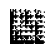

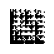

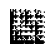

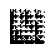

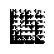

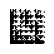

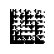

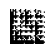

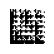

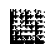

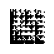

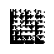

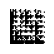

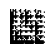

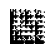

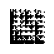

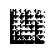

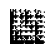

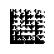

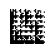

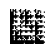

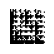

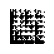

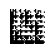

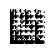

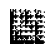

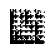

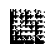

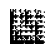

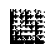

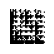

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>10, 20/30, d=1.100, g=0.453
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
>Accuracy real: 0%, fake: 0%


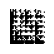

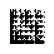

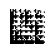

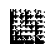

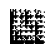

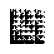

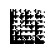

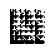

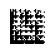

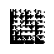

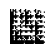

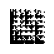

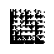

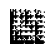

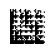

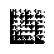

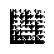

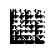

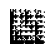

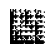

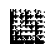

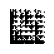

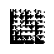

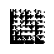

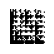

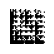

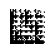

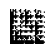

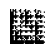

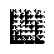

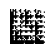

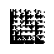

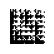

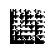

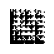

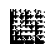

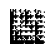

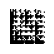

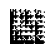

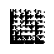

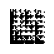

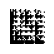

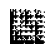

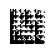

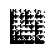

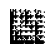

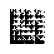

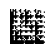

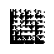

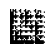

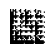

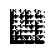

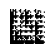

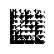

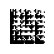

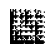

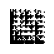

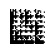

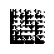

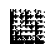

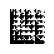

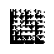

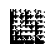

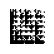

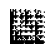

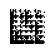

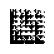

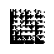

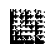

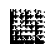

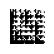

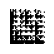

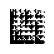

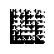

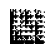

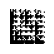

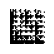

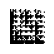

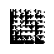

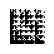

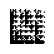

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>10, 21/30, d=1.101, g=0.453
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>Accuracy real: 0%, fake: 0%


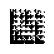

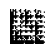

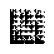

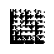

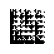

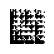

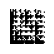

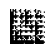

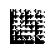

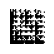

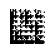

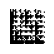

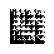

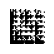

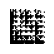

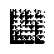

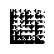

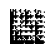

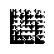

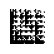

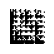

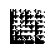

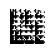

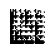

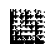

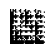

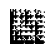

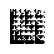

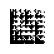

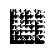

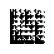

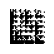

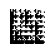

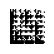

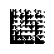

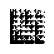

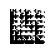

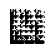

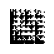

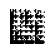

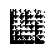

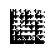

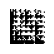

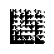

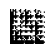

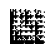

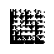

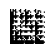

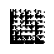

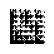

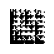

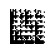

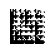

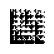

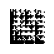

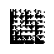

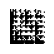

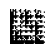

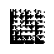

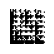

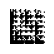

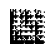

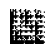

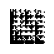

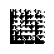

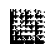

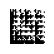

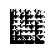

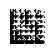

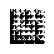

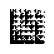

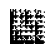

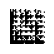

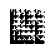

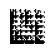

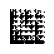

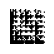

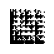

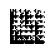

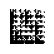

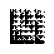

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>10, 22/30, d=1.099, g=0.453
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>Accuracy real: 0%, fake: 0%


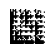

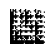

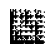

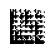

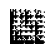

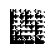

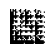

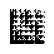

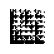

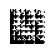

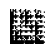

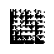

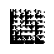

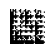

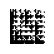

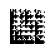

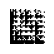

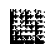

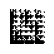

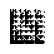

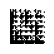

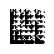

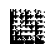

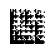

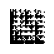

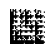

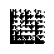

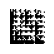

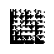

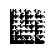

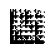

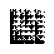

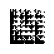

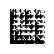

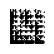

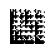

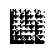

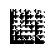

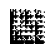

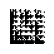

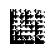

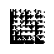

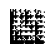

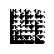

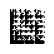

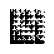

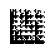

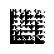

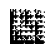

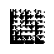

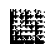

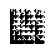

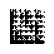

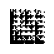

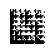

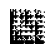

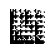

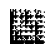

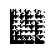

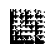

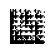

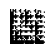

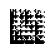

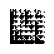

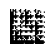

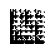

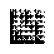

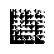

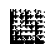

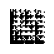

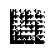

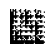

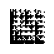

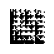

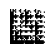

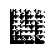

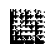

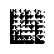

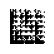

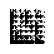

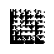

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>10, 23/30, d=1.102, g=0.452
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>Accuracy real: 0%, fake: 0%


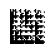

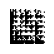

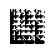

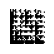

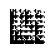

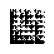

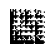

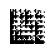

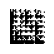

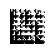

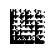

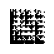

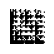

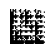

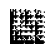

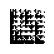

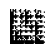

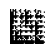

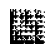

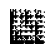

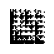

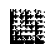

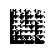

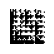

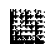

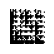

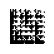

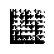

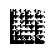

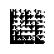

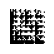

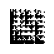

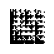

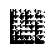

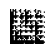

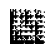

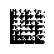

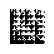

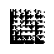

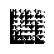

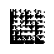

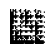

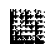

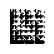

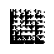

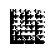

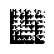

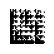

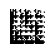

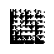

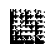

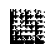

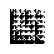

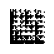

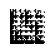

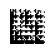

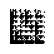

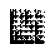

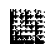

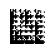

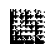

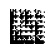

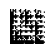

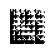

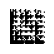

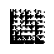

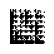

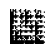

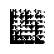

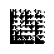

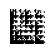

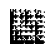

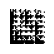

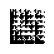

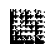

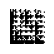

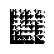

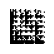

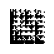

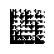

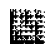

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>10, 24/30, d=1.099, g=0.452
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>Accuracy real: 0%, fake: 0%


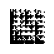

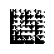

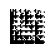

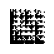

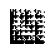

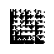

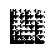

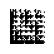

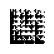

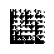

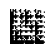

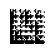

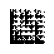

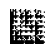

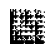

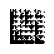

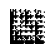

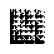

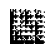

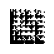

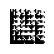

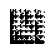

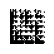

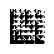

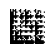

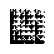

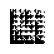

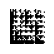

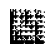

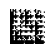

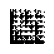

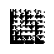

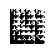

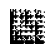

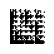

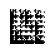

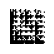

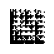

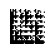

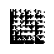

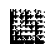

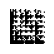

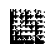

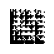

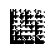

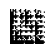

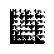

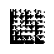

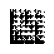

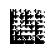

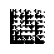

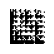

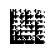

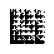

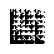

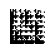

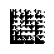

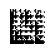

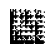

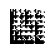

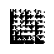

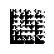

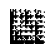

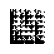

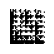

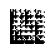

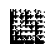

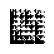

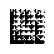

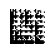

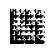

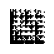

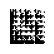

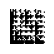

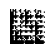

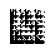

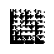

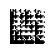

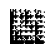

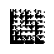

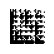

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>10, 25/30, d=1.100, g=0.452
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
>Accuracy real: 0%, fake: 0%


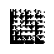

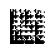

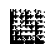

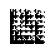

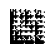

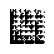

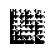

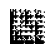

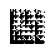

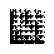

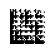

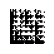

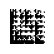

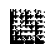

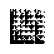

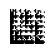

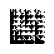

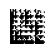

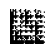

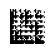

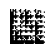

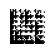

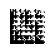

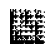

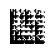

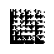

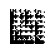

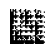

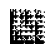

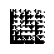

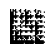

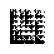

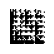

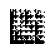

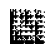

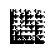

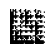

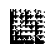

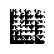

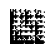

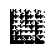

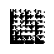

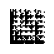

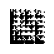

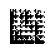

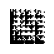

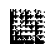

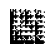

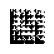

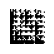

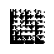

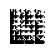

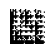

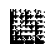

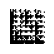

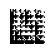

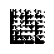

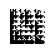

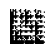

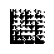

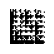

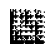

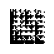

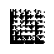

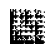

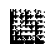

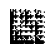

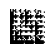

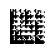

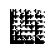

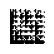

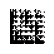

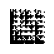

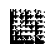

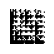

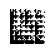

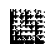

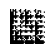

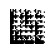

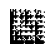

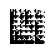

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>10, 26/30, d=1.099, g=0.452
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
>Accuracy real: 0%, fake: 0%


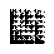

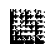

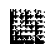

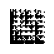

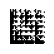

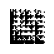

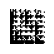

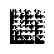

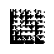

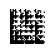

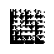

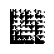

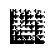

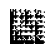

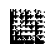

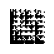

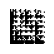

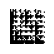

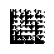

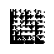

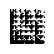

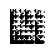

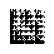

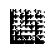

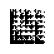

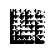

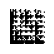

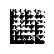

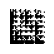

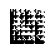

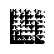

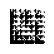

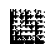

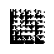

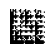

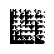

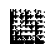

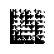

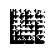

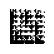

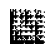

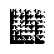

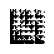

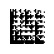

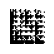

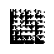

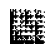

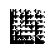

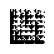

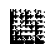

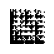

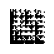

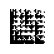

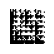

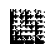

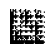

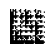

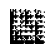

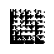

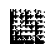

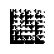

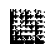

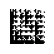

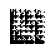

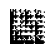

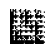

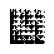

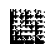

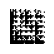

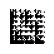

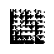

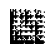

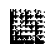

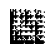

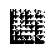

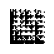

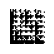

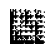

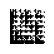

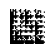

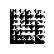

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>10, 27/30, d=1.100, g=0.451
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>Accuracy real: 0%, fake: 0%


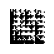

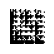

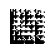

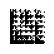

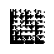

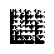

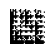

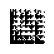

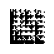

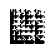

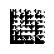

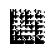

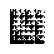

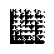

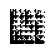

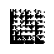

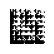

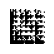

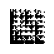

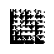

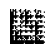

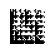

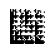

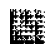

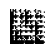

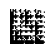

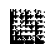

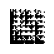

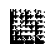

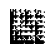

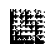

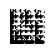

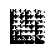

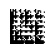

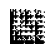

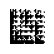

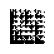

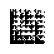

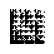

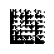

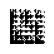

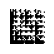

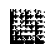

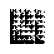

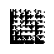

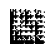

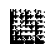

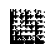

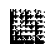

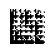

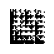

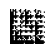

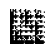

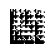

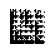

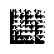

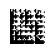

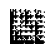

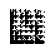

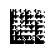

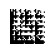

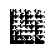

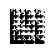

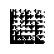

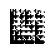

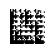

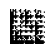

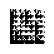

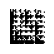

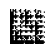

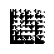

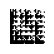

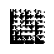

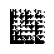

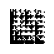

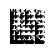

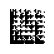

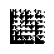

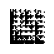

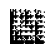

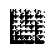

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>10, 28/30, d=1.099, g=0.451
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>Accuracy real: 0%, fake: 0%


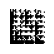

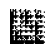

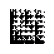

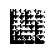

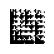

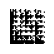

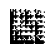

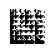

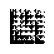

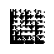

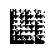

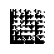

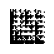

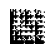

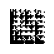

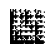

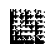

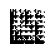

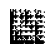

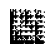

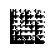

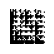

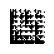

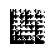

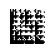

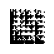

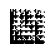

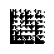

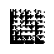

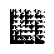

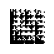

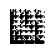

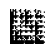

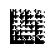

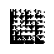

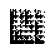

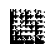

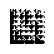

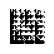

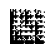

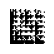

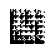

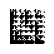

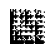

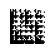

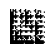

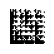

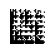

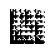

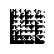

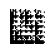

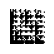

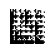

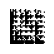

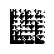

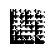

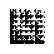

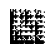

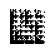

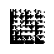

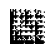

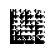

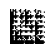

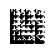

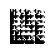

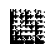

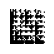

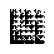

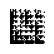

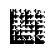

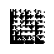

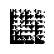

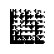

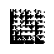

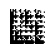

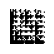

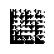

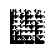

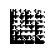

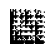

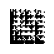

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>10, 29/30, d=1.101, g=0.451
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
>Accuracy real: 0%, fake: 0%


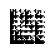

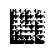

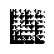

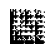

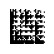

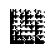

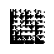

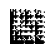

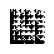

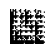

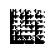

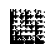

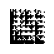

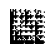

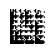

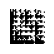

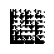

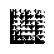

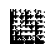

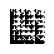

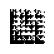

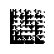

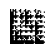

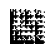

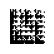

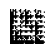

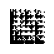

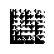

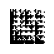

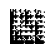

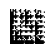

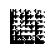

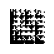

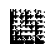

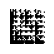

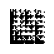

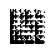

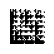

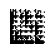

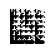

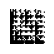

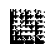

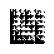

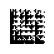

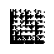

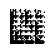

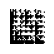

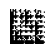

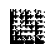

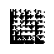

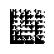

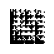

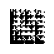

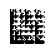

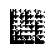

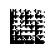

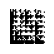

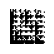

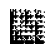

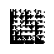

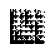

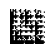

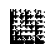

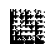

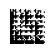

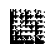

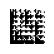

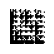

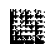

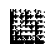

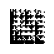

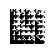

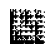

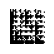

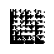

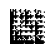

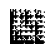

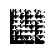

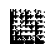

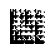

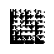

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>10, 30/30, d=1.101, g=0.451
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>Accuracy real: 0%, fake: 0%


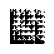

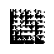

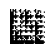

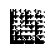

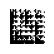

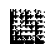

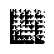

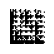

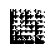

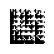

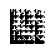

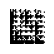

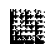

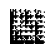

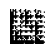

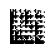

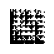

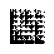

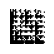

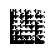

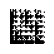

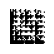

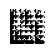

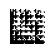

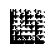

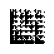

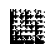

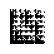

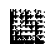

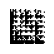

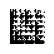

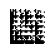

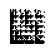

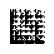

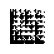

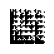

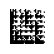

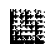

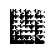

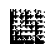

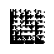

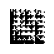

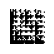

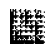

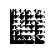

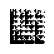

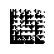

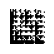

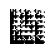

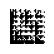

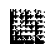

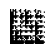

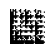

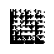

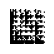

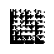

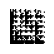

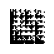

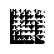

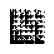

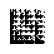

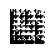

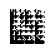

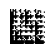

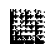

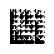

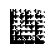

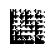

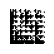

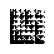

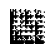

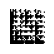

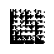

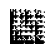

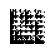

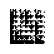

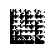

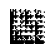

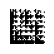

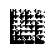

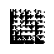

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>11, 1/30, d=1.102, g=0.451
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
>11, 2/30, d=1.070, g=0.450
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
>11, 3/30, d=1.046, g=0.450
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
>11, 4/30, d=1.029, g=0.450
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
>11, 5/30, d=1.016, g=0.450
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
>11, 6/30, d=1.005, g=0.450
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
>11, 7/30, d=0.995, g=0.450
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
>11, 8/30, d=0.988, g=0.449
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
>11, 9/30, d=0.982, g=0.449
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
>11, 10/30, d=0.978, g=0.449
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>11, 11/30, d=0.973, g=0.449
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
>11, 12/30, d=0.969, g=0.449
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
>11, 13/30, d=0.966, g=0.448
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
>11, 14/30, d=0.962, g=0.448
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
>11, 15/30, d=0.960, g=0.448
4/4 

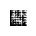

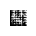

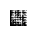

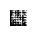

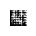

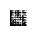

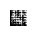

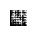

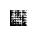

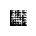

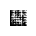

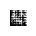

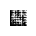

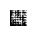

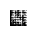

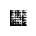

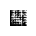

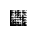

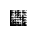

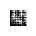

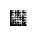

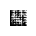

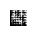

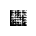

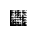

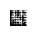

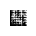

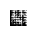

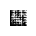

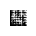

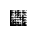

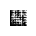

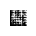

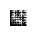

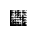

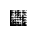

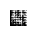

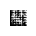

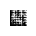

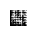

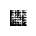

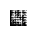

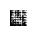

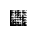

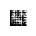

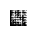

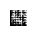

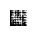

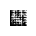

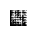

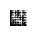

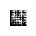

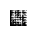

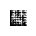

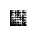

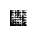

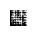

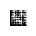

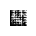

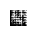

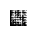

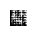

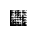

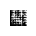

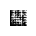

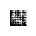

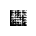

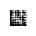

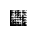

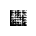

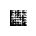

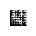

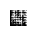

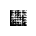

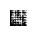

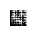

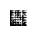

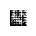

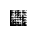

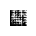

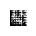

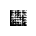

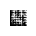

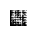

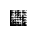

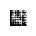

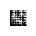

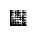

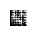

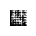

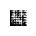

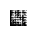

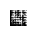

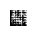

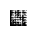

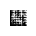

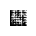

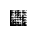

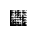

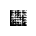

IndexError: index 100 is out of bounds for axis 0 with size 100

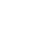

In [24]:

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples(resized_images)
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)
# load model
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = g_model.predict(latent_points)
# plot the result
save_plot(X, 5)

In [ ]:
print(int(dataset.shape[0] / 256))

0
